In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Load

## obj_fibroblasts

In [2]:
dname <- '/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/'
fields_load <- c('meta_data', 'effects_nested', 'effects_marginal')
# fields_load <- c('meta_data', 'umap_after', 'umap_before', 'V', 'V_unweighted', 'effects_nested', 'effects_marginal')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(tissue_cluster = case_when(
        tissue_cluster == 'NOTCH3+ perivascular' ~ 'Sublining',
        TRUE ~ tissue_cluster
    ))

# %>% 
#     with(table(tissue_cluster))


In [3]:
masc_res <- readRDS('/data/srlab2/ik936/Roche/data/cache/confusion_analysis_results.rds')


## adams

In [4]:
adams <- readRDS('/data/srlab2/ik936/Roche/data/lung/Adams/query.rds')
adams$effects <- readRDS('/data/srlab2/ik936/Roche/data/lung/Adams/effects.rds')
# adams$masc_res <- readRDS('/data/srlab2/ik936/Roche/data/lung/Adams/masc_res.rds')
adams$frequencies <- readRDS('/data/srlab2/ik936/Roche/data/cache/adams_ttest_frequencies.rds')

## travaglini

In [5]:
trav <- readRDS('/data/srlab2/ik936/Roche/data/lung/Travaglini/obj_mesenchymal')

# UMAPs

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


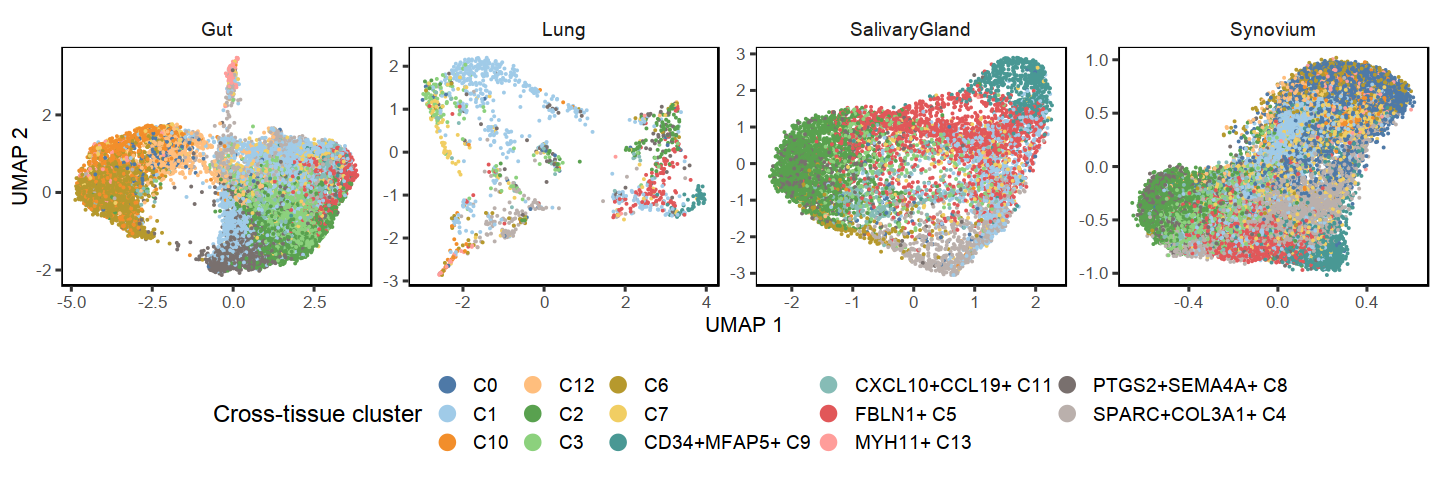

In [6]:
fig.size(4, 12)
p1 <- do_scatter(
    dplyr::select(obj$meta_data, matches('UMAP._tissue')), 
    dplyr::select(obj$meta_data, -matches('UMAP')), 
    'Cluster_name',
    pt_shape = 16, point_size = .5, 
    do_labels = FALSE, no_guides = FALSE
) + 
    facet_wrap(~Tissue, scales = 'free', nrow = 1) + 
    labs(
        color = 'Cross-tissue cluster',
        fill = 'Cross-tissue cluster'
    ) + 
    theme(legend.position = 'bottom') + 
    NULL

p1

# Barplots

Within a given Integrated-Cluster, what are the odds of being one or another tissue-cluster? 



In [7]:
masc_res <- readRDS('/data/srlab2/ik936/Roche/data/cache/confusion_analysis_results.rds')


tissue_cluster_levels <- obj$meta_data %>% 
    dplyr::select(tissue_cluster, Tissue) %>% 
    unique() %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('SalivaryGland', 'Lung', 'Synovium', 'Gut'))) %>%  
    arrange(Tissue) %>% 
    with(tissue_cluster)

In [8]:
plt_df <- masc_res %>% 
    dplyr::mutate(prob = exp(beta)) %>% 
    split(paste0(.$Cluster, .$Tissue)) %>% 
    map(function(.SD) {
        .SD$prob <- prop.table(.SD$prob)
        return(.SD)
    }) %>% 
    bind_rows() %>% 
    dplyr::select(Cluster, Tissue, tissue_cluster, prob) %>% 
    left_join(unique(dplyr::select(obj$meta_data, Cluster_name, Cluster))) %>% 
    dplyr::mutate(tissue_cluster = factor(tissue_cluster, tissue_cluster_levels))


Joining, by = "Cluster"



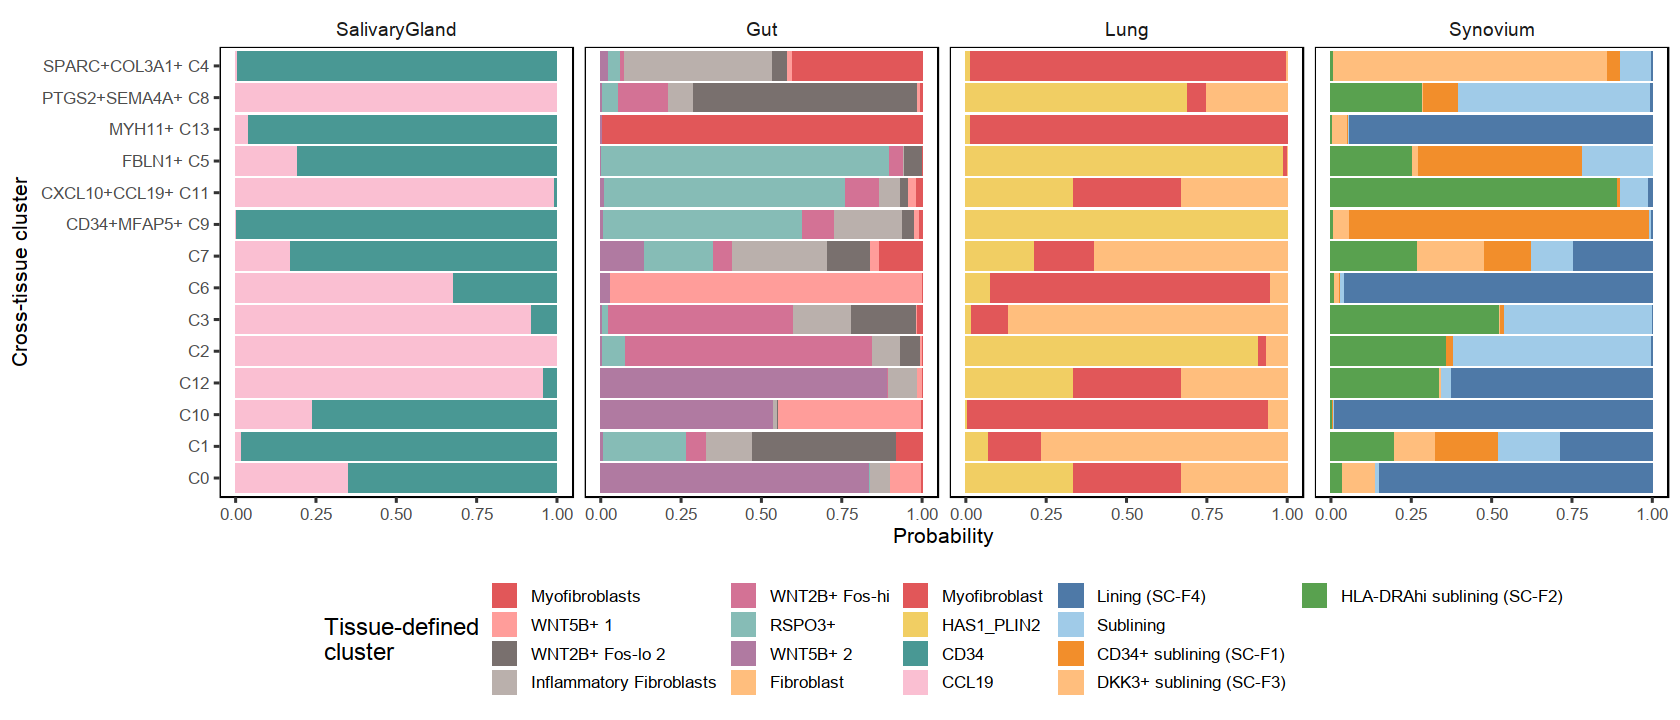

In [9]:
fig.size(6, 14)
p2 <- plt_df %>% 
    ggplot(aes(Cluster_name, prob, fill = tissue_cluster)) + 
        geom_bar(stat = 'identity') + 
        coord_flip() + 
#         labs(title = .tissue) + 
        labs(
            x = 'Cross-tissue cluster', y = 'Probability',
            color = 'Tissue-defined\ncluster', 
            fill = 'Tissue-defined\ncluster'
        ) +
        facet_wrap(~Tissue, nrow=1) + 
        scale_fill_manual(values = palette_global[as.character(unique(plt_df$tissue_cluster))]) + 
        theme(
            legend.position = 'bottom', legend.text = element_text(size = 10),
            axis.title = element_text(size=12)
        ) + 
        guides(fill = guide_legend(override.aes = list(size=1))) + 
        NULL
p2

# Heatmap

In [10]:
res_wide <- masc_res %>% 
    arrange(-sigma) %>% 
    left_join(unique(dplyr::select(obj$meta_data, Cluster, Cluster_name))) %>%
    dplyr::select(Tissue, tissue_cluster, Cluster_name, beta) %>% 
    tidyr::spread(Cluster_name, beta) %>% 
    subset(!tissue_cluster %in% c(''))

# head(res_wide)


Joining, by = "Cluster"



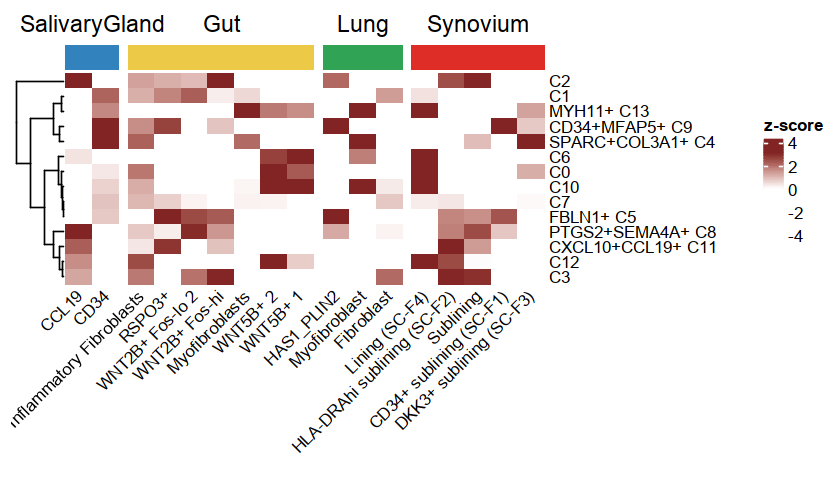

In [16]:
fig.size(4, 7)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))


h1 <- split(seq(nrow(res_wide)), res_wide$Tissue) %>% 
    imap(function(idx, the_tissue) {
        X <- res_wide[idx, , drop = FALSE] %>% 
            dplyr::select(-Tissue) %>% 
            tibble::column_to_rownames('tissue_cluster') %>% 
            as.matrix() %>% 
#             pmax(0) %>% 
            t()
        if (the_tissue == 'Synovium') {
            Heatmap(
                X,
                name = 'z-score',
                column_title = the_tissue, 
                show_column_dend = FALSE,
                column_title_side = 'top',
                col = colorRamp2(c(-3, 0, 3), c("white", "white", muted("red"))),
                column_names_rot = 45,
                    top_annotation = columnAnnotation(
                        df = data.frame(Tissue = rep(the_tissue, length(idx))),
                        show_annotation_name = FALSE,
                        show_legend = FALSE, 
                        col = palette_heatmap
                    ),
    #                 name = 'Log\nOdds\nRatio', 
                    show_heatmap_legend = TRUE, 
            )
            
        } else {
            Heatmap(
                X,
                column_title = the_tissue, 
                show_column_dend = FALSE,
                column_title_side = 'top',
                col = colorRamp2(c(-3, 0, 3), c("white", "white", muted("red"))),
                column_names_rot = 45,
                    top_annotation = columnAnnotation(
                        df = data.frame(Tissue = rep(the_tissue, length(idx))),
                        show_annotation_name = FALSE,
                        show_legend = FALSE, 
                        col = palette_heatmap
                    ),
    #                 name = 'Log\nOdds\nRatio', 
                    show_heatmap_legend = FALSE, 
            )
            
        }
        }) %>% 
    reduce(`+`)


p3 <- grid.grabExpr(draw(h1, padding = unit(c(1, 1, 1, 7), "mm"), heatmap_legend_side = 'right')) #bottom, left, top, right paddings
wrap_elements(p3)

# C13 genes - lung and gut

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


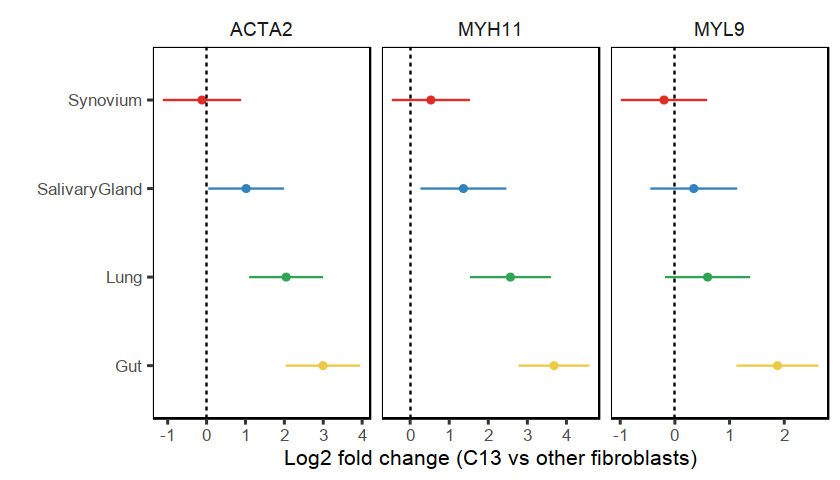

In [12]:
p4 <- obj$effects_nested %>% 
    subset(Cluster == '13' & feature %in% c('ACTA2', 'MYH11', 'MYL9')) %>% 
    ggplot(aes(Tissue, beta, color = Tissue)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
        coord_flip() + 
        facet_wrap(~feature, scales = 'free_x') + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        labs(x = "", y = "Log2 fold change (C13 vs other fibroblasts)") +
        guides(color = FALSE) + 
        NULL
    
p4


# C13 genes - synovium

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


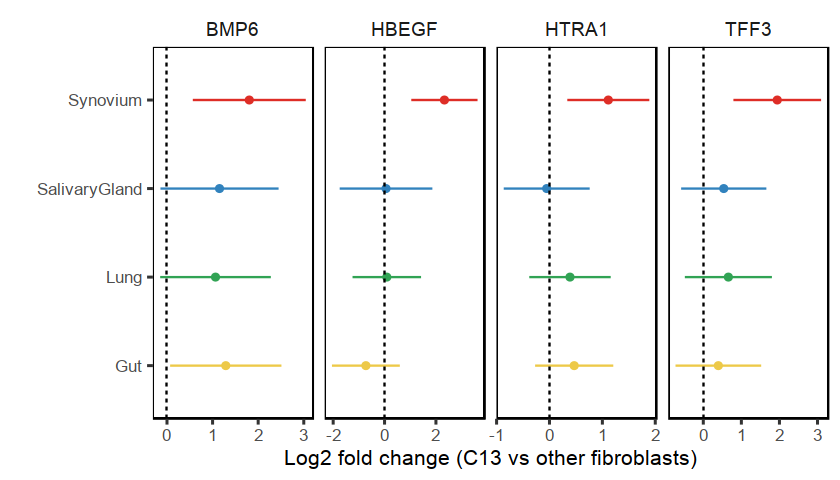

In [13]:
p5 <- obj$effects_nested %>% 
    subset(Cluster == '13' & feature %in% c('TFF3', 'BMP6', 'HTRA1', 'HBEGF')) %>% 
    ggplot(aes(Tissue, beta, color = Tissue)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
        coord_flip() + 
        facet_wrap(~feature, scales = 'free_x', nrow = 1) + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        labs(x = "", y = "Log2 fold change (C13 vs other fibroblasts)") +
        guides(color = FALSE) + 
        NULL
    
p5


# Panels

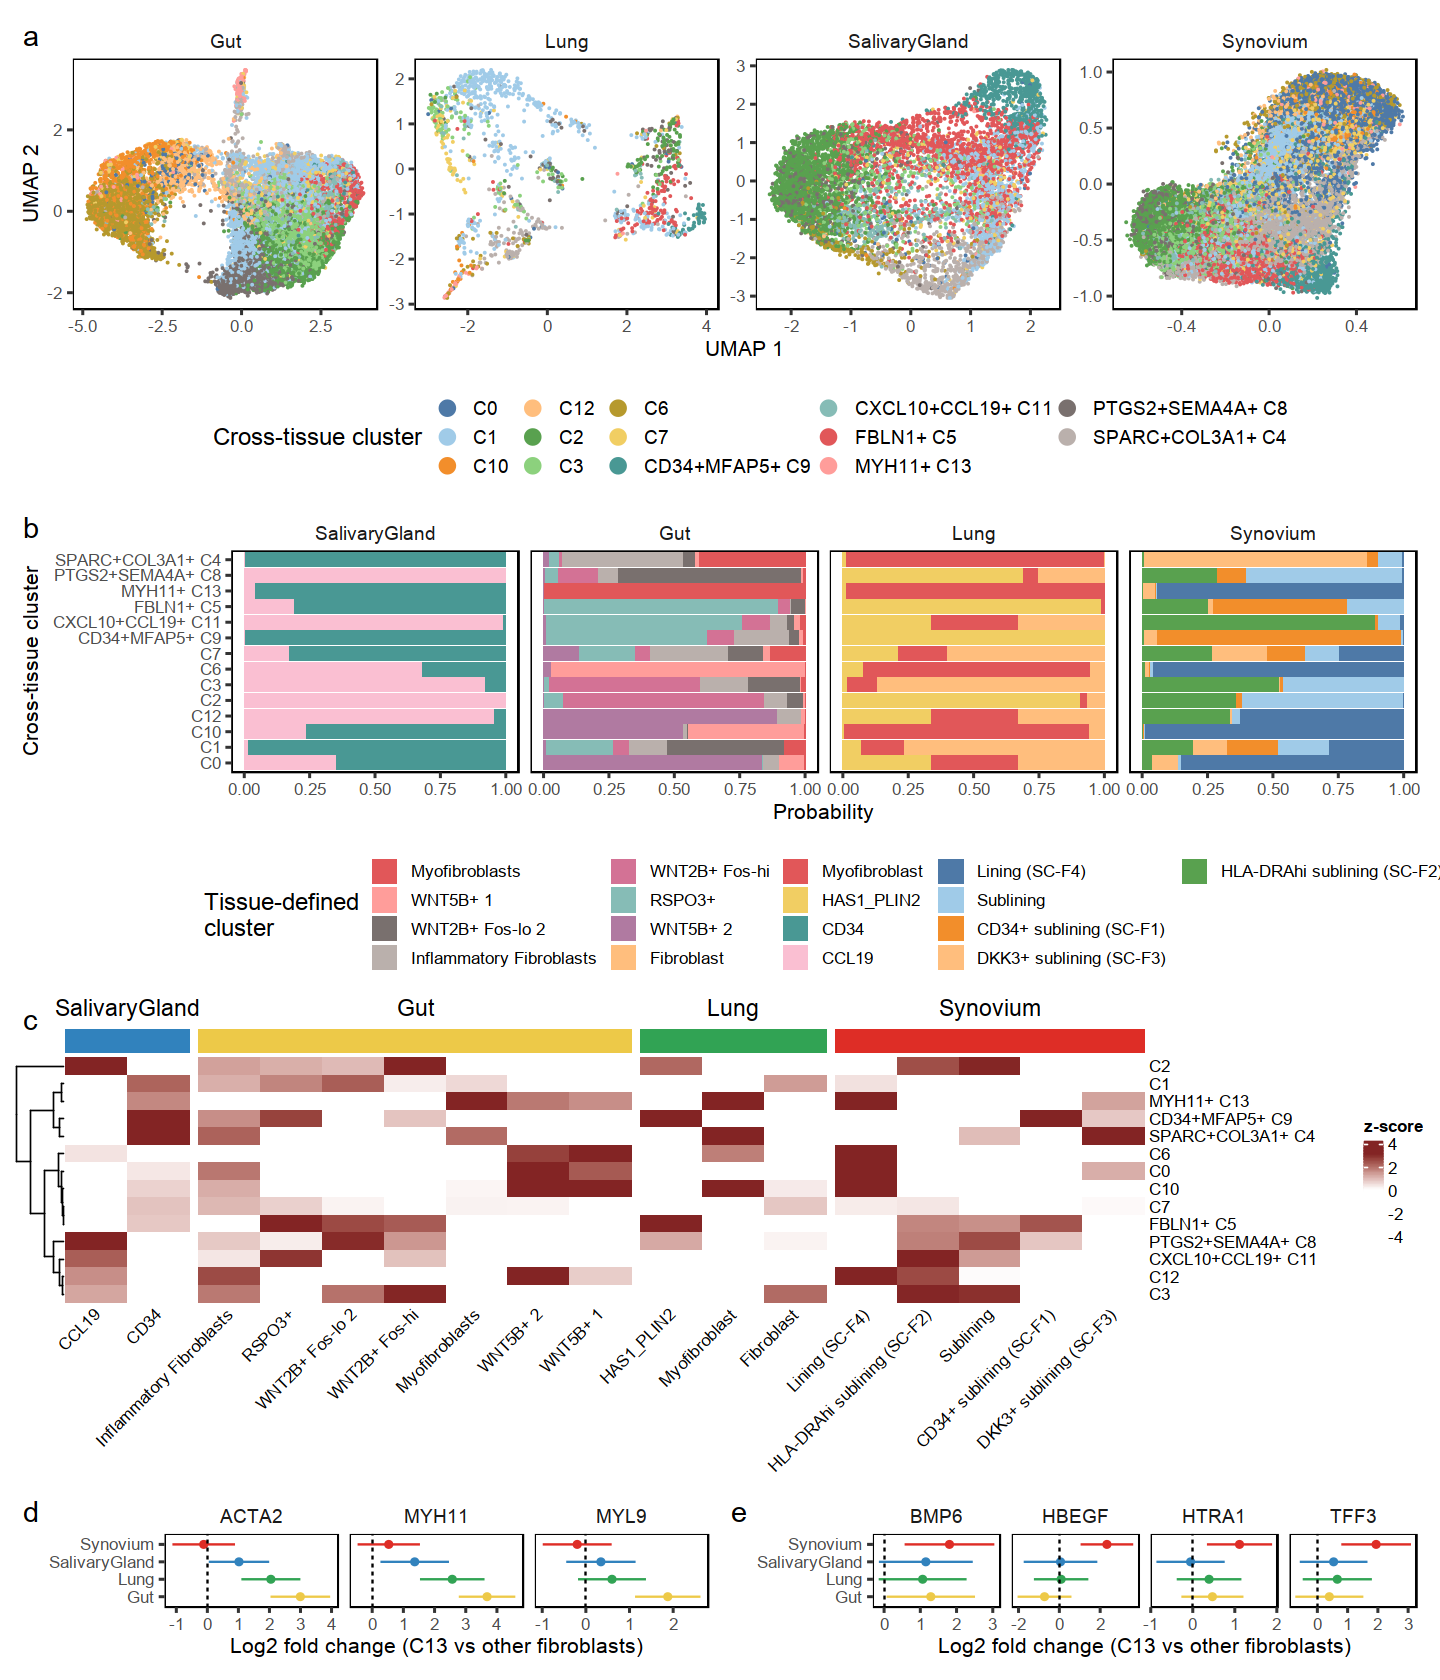

In [17]:
fig.size(14, 12)
main_figure <- (
    wrap_elements(full = p1) / 
    wrap_elements(full = p2) / 
    wrap_elements(full = p3) / 
    (
        wrap_elements(full = p4) | wrap_elements(full = p5)
    )
) + 
    plot_layout(heights = c(1, 1, 1, .3)) + 
    plot_annotation(tag_levels = 'a')


main_figure


In [18]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/SuppFigure4.pdf', 
    plot = main_figure, 
    units = 'in', device = 'pdf', 
    height = 14, width = 12,
    useDingbats = FALSE
)
